In [1]:
import Pkg

using Flux
using Flux: onehotbatch, onecold, crossentropy
using MLDatasets
using CSV
using Random
using DataFrames
using Optimisers
using Statistics
using Plots

using DecisionTree


In [2]:
sunspot_data = CSV.read("Sunspot_data.csv", DataFrame)

sunspots = sunspot_data[:, 3];

In [13]:
function create_sequences(data, seq_len)
    X, y = [], []
    for i in 1:(length(data) - seq_len)
        push!(X, data[i:i+seq_len-1])
        push!(y, data[i+seq_len])
    end
    return hcat(X...), y  # Convert to matrix form
end

seq_len = 50  # Lookback window
X, y = create_sequences(sunspots, seq_len)

# Normalize
X = (X .- mean(X)) ./ std(X)
y = (y .- mean(y)) ./ std(y)

train_ratio = 0.9


split_var = Int(train_ratio * size(X, 2))

X_train, y_train = X[:, 1:split_var], y[1:split_var]
X_test, y_test = X[:, split_var+1:end], y[split_var+1:end]

X_train = reshape(X_train, size(X_train, 1), 1, size(X_train, 2))
X_test = reshape(X_test, size(X_test, 1), 1, size(X_test, 2))

y_train = reshape(y_train, 1, length(y_train))  # Convert to (1, batch_size)
y_test = reshape(y_test, 1, length(y_test))    # Convert to (1, batch_size)
;

In [23]:
# Data should be stored in WHCN order (width, height, # channels, batch size). 
# In other words, a 100×100 RGB image would be a 100×100×3×1 array, and a batch of 50 would be a 100×100×3×50 array.

model = Chain(
    Conv((5,), 1=>16, relu),
    MaxPool((2,)),
    BatchNorm(16),
    Conv((3,), 16=>32, relu),
    MaxPool((2,)),
    BatchNorm(32),
    Flux.flatten,
    Dense(320, 64, relu),  
    Dense(64, 10, relu),
    Dense(10, 1),
     )    # Output a single prediction)

     

Chain(
  Conv((5,), 1 => 16, relu),            # 96 parameters
  MaxPool((2,)),
  BatchNorm(16),                        # 32 parameters, plus 32
  Conv((3,), 16 => 32, relu),           # 1_568 parameters
  MaxPool((2,)),
  BatchNorm(32),                        # 64 parameters, plus 64
  Flux.flatten,
  Dense(320 => 64, relu),               # 20_544 parameters
  Dense(64 => 10, relu),                # 650 parameters
  Dense(10 => 1),                       # 11 parameters
)         # Total: 14 trainable arrays, 22_965 parameters,
          # plus 4 non-trainable, 96 parameters, summarysize 91.184 KiB.

In [24]:
epochs = 200
batch_size = 64;

In [16]:
opt = ADAM()

data_loader = Flux.DataLoader((X_train, y_train), batchsize=batch_size, shuffle=true)

# Initialize optimizer state
opt_state = Flux.setup(opt, model)  

total_loss = []

for epoch in 1:epochs
    epoch_loss = 0
    for (x, y) in data_loader
        gs = Flux.gradient(model -> Flux.Losses.mse(model(x), y), model)[1]  
        Flux.update!(opt_state, Flux.trainable(model), gs)
        epoch_loss += Flux.Losses.mse(model(x), y)
    end
    println("Epoch $epoch - Train Loss: $epoch_loss")
    push!(total_loss, epoch_loss)
end


Epoch 1 - Train Loss: 23.46209996461772
Epoch 2 - Train Loss: 7.300552759536725
Epoch 3 - Train Loss: 6.046928738229113
Epoch 4 - Train Loss: 5.507985124278835
Epoch 5 - Train Loss: 4.965094054514106
Epoch 6 - Train Loss: 4.69428418488573
Epoch 7 - Train Loss: 4.418669026440467
Epoch 8 - Train Loss: 4.452384346070442
Epoch 9 - Train Loss: 3.7427587463952228
Epoch 10 - Train Loss: 3.745737743307859
Epoch 11 - Train Loss: 3.5727489512788164
Epoch 12 - Train Loss: 3.58683807947592
Epoch 13 - Train Loss: 3.446055454901473
Epoch 14 - Train Loss: 3.1985260314733437
Epoch 15 - Train Loss: 3.122832968995064
Epoch 16 - Train Loss: 2.8950364331568004
Epoch 17 - Train Loss: 2.66601582158131
Epoch 18 - Train Loss: 2.6712702469497716
Epoch 19 - Train Loss: 2.640112171814583
Epoch 20 - Train Loss: 2.633824426135524
Epoch 21 - Train Loss: 2.392330031805745
Epoch 22 - Train Loss: 2.218078053432966
Epoch 23 - Train Loss: 2.3032784054149134
Epoch 24 - Train Loss: 2.070994662839992
Epoch 25 - Train Loss:

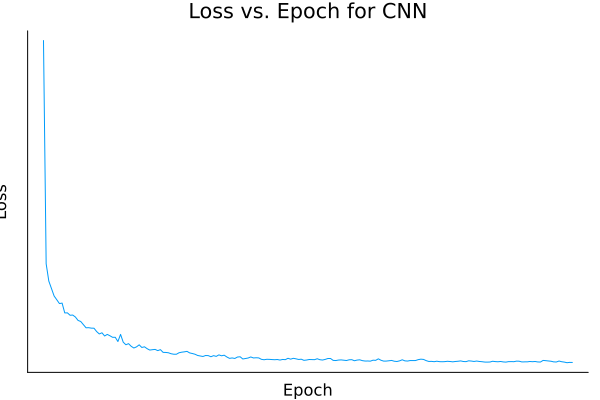

In [17]:
p1 = plot(1:epochs, total_loss, xlabel="Epoch", ylabel="Loss", title="Loss vs. Epoch for CNN", legend=false, xticks=false, yticks=false)
display(p1)

In [18]:
model_DNN = Chain(
    Dense(50, 64, relu),
    Dense(64, 128, relu),
    Dense(128, 64, relu),
    Dense(64, 32, relu),
    Dense(32, 1)
)


Chain(
  Dense(50 => 64, relu),                # 3_264 parameters
  Dense(64 => 128, relu),               # 8_320 parameters
  Dense(128 => 64, relu),               # 8_256 parameters
  Dense(64 => 32, relu),                # 2_080 parameters
  Dense(32 => 1),                       # 33 parameters
)                   # Total: 10 arrays, 21_953 parameters, 86.262 KiB.

In [19]:

opt_state_DNN = Flux.setup(opt, model_DNN)  

for epoch in 1:epochs
    for (x, y) in data_loader
        gs = Flux.gradient(model_DNN -> Flux.Losses.mse(Flux.flatten(model_DNN(x)), y), model_DNN)[1]  
        Flux.update!(opt_state_DNN, Flux.trainable(model_DNN), gs)
    end
    println("Epoch $epoch")
end


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110
Epoch 11

In [20]:
preds_CNN = model(X_test)
preds_DNN = model_DNN(X_test)
;

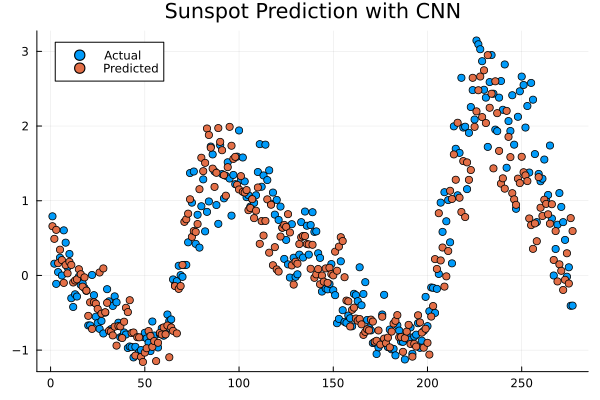

In [21]:
scatter(1:length(y_test[1, :]), y_test[1, :], label="Actual", title="Sunspot Prediction with CNN")
scatter!(1:length(preds_CNN[1, :]), preds_CNN[1, :], label="Predicted")

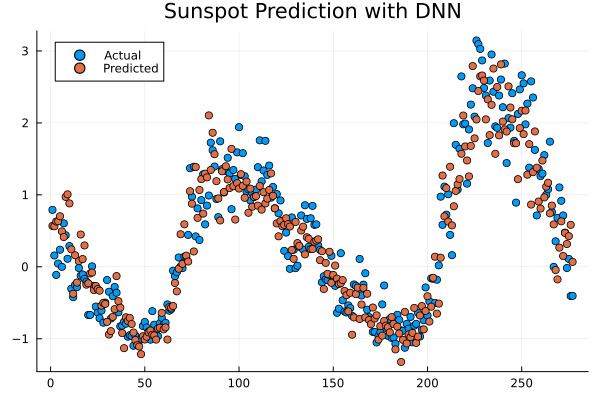

In [22]:
scatter(1:length(y_test[1, :]), y_test[1, :], label="Actual", title="Sunspot Prediction with DNN")
scatter!(1:length(vec(preds_DNN)), vec(preds_DNN), label="Predicted")